# 🎯 Model Training TEMPORAL - Validación Profesional

**Objetivo:** Entrenar modelos con predicción temporal y validación rigurosa

**Approach Profesional:**
- 📊 Temporal Split: Train en fechas antiguas, Test en fechas recientes
- 🎯 Target futuro: Predecir riesgo en T+7 días
- ✅ Sin data leakage: Solo features históricas/tendencias
- 📈 Métricas realistas: Accuracy esperado 70-85%

**Autor:** Asier Ortiz García  
**Fecha:** Noviembre 2025

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import pickle
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    f1_score, precision_score, recall_score
)
from imblearn.over_sampling import SMOTE

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (14, 6)

Path('../models/crohn').mkdir(parents=True, exist_ok=True)
Path('../models/cu').mkdir(parents=True, exist_ok=True)
Path('../docs/figures').mkdir(parents=True, exist_ok=True)

print("=" * 80)
print("MODEL TRAINING TEMPORAL - VALIDACIÓN PROFESIONAL")
print("=" * 80)

MODEL TRAINING TEMPORAL - VALIDACIÓN PROFESIONAL


## 📊 Funciones de Visualización

In [2]:
def plot_confusion_matrix(y_true, y_pred, title, save_path=None):
    """Plot confusion matrix con porcentajes."""
    cm = confusion_matrix(y_true, y_pred, labels=['low', 'medium', 'high'])
    
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Low', 'Medium', 'High'],
                yticklabels=['Low', 'Medium', 'High'],
                ax=ax, cbar_kws={'label': 'Count'})
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)
    
    # Add percentages
    total = cm.sum()
    for i in range(3):
        for j in range(3):
            pct = cm[i, j] / total * 100
            ax.text(j+0.5, i+0.7, f'({pct:.1f}%)', 
                   ha='center', va='center', fontsize=9, color='gray')
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_feature_importance(model, feature_names, title, save_path=None, top_n=20):
    """Plot top N feature importance."""
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1][:top_n]
    
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.barh(range(top_n), importances[indices], color='steelblue', edgecolor='black')
    ax.set_yticks(range(top_n))
    ax.set_yticklabels([feature_names[i] for i in indices])
    ax.invert_yaxis()
    ax.set_xlabel('Importance', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_learning_curves(model, X, y, title, save_path=None):
    """Plot learning curves para detectar overfitting."""
    from sklearn.model_selection import learning_curve
    
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, cv=5, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='accuracy', random_state=42
    )
    
    train_mean = train_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    val_mean = val_scores.mean(axis=1)
    val_std = val_scores.std(axis=1)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(train_sizes, train_mean, 'o-', color='blue', label='Training score')
    ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
    ax.plot(train_sizes, val_mean, 'o-', color='red', label='Cross-validation score')
    ax.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='red')
    
    ax.set_xlabel('Training Size', fontsize=12)
    ax.set_ylabel('Accuracy', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    
    # Add gap indicator
    gap = train_mean[-1] - val_mean[-1]
    ax.text(0.5, 0.05, f'Train-Val Gap: {gap:.3f}', 
            transform=ax.transAxes, fontsize=11,
            bbox=dict(boxstyle='round', facecolor='yellow' if gap > 0.1 else 'lightgreen', alpha=0.5))
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_roc_curves(y_true, y_pred_proba, title, save_path=None):
    """Plot ROC curves para multiclass (one-vs-rest)."""
    from sklearn.preprocessing import label_binarize
    from sklearn.metrics import roc_curve, roc_auc_score
    
    classes = ['low', 'medium', 'high']
    y_true_bin = label_binarize(y_true, classes=classes)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    for i, class_name in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
        auc = roc_auc_score(y_true_bin[:, i], y_pred_proba[:, i])
        ax.plot(fpr, tpr, label=f'{class_name.capitalize()} (AUC = {auc:.3f})', linewidth=2)
    
    ax.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.500)')
    ax.set_xlabel('False Positive Rate', fontsize=12)
    ax.set_ylabel('True Positive Rate', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

print("✓ Funciones de visualización definidas (completas)")

✓ Funciones de visualización definidas (completas)


## 🔧 Función de Entrenamiento Temporal

In [3]:
def train_temporal(ibd_type='crohn'):
    print(f"\n{'='*80}")
    print(f"ENTRENANDO: {ibd_type.upper()} - TEMPORAL VALIDATION")
    print(f"{'='*80}\n")
    
    # Load temporal dataset
    df = pd.read_csv(f'../data/processed/{ibd_type}/ml_dataset_temporal.csv')
    df['checkin_date'] = pd.to_datetime(df['checkin_date'])
    
    print(f"✓ Dataset temporal cargado: {len(df):,} registros")
    print(f"  Distribución target: {df['risk_level_future'].value_counts().to_dict()}")
    
    # Features
    exclude_cols = ['user_id', 'checkin_date', 'risk_level_future', 'gender']
    feature_cols = [col for col in df.columns if col not in exclude_cols]
    
    X = df[feature_cols].copy()
    y = df['risk_level_future'].copy()
    
    # One-hot encode gender
    if 'gender' in df.columns:
        X = pd.concat([X, pd.get_dummies(df['gender'], prefix='gender', drop_first=True)], axis=1)
    
    print(f"\n✅ Features: {len(X.columns)}")
    print(f"  {list(X.columns)}")
    
    # ⏱️ TEMPORAL SPLIT (NO random!)
    df_sorted = df.sort_values('checkin_date')
    split_idx = int(len(df_sorted) * 0.8)
    split_date = df_sorted.iloc[split_idx]['checkin_date']
    
    train_mask = df['checkin_date'] < split_date
    test_mask = df['checkin_date'] >= split_date
    
    X_train = X[train_mask]
    X_test = X[test_mask]
    y_train = y[train_mask]
    y_test = y[test_mask]
    
    print(f"\n⏱️ TEMPORAL SPLIT:")
    print(f"  Split date: {split_date.date()}")
    print(f"  Train: {len(X_train):,} registros (antes de {split_date.date()})")
    print(f"  Test: {len(X_test):,} registros (desde {split_date.date()})")
    print(f"  Train distribution: {y_train.value_counts().to_dict()}")
    print(f"  Test distribution: {y_test.value_counts().to_dict()}")
    
    # SMOTE
    print(f"\n🔄 Aplicando SMOTE...")
    smote = SMOTE(sampling_strategy='not majority', random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
    print(f"  Antes: {len(X_train):,} | Después: {len(X_train_res):,}")
    
    # Cross-validation
    print(f"\n1️⃣ CROSS-VALIDATION (5-fold)...")
    rf_model = RandomForestClassifier(
        n_estimators=200, max_depth=15, min_samples_split=10,
        random_state=42, n_jobs=-1, class_weight='balanced'
    )
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(rf_model, X_train_res, y_train_res, cv=cv, scoring='accuracy', n_jobs=-1)
    
    print(f"  CV Accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std():.3f})")
    
    # Train final model
    print(f"\n2️⃣ Entrenando modelo final...")
    rf_model.fit(X_train_res, y_train_res)
    
    # Evaluate
    y_pred = rf_model.predict(X_test)
    y_pred_proba = rf_model.predict_proba(X_test)
    test_acc = accuracy_score(y_test, y_pred)
    test_f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"\n✅ RESULTADOS TEMPORALES:")
    print(f"  CV Accuracy: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
    print(f"  Test Accuracy: {test_acc:.3f}")
    print(f"  Test F1-score: {test_f1:.3f}")
    print(f"  Gap (CV vs Test): {abs(cv_scores.mean() - test_acc):.3f}")
    
    print(f"\n📊 Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))
    
    # 3. DIAGNOSTIC PLOTS (4 tipos)
    print(f"\n3️⃣ Generando gráficos de diagnóstico...")
    
    # 3.1 Confusion Matrix
    plot_confusion_matrix(
        y_test, y_pred,
        f'Confusion Matrix TEMPORAL - {ibd_type.upper()}',
        f'../docs/figures/{ibd_type}_confusion_matrix_temporal.png'
    )
    
    # 3.2 Feature Importance
    plot_feature_importance(
        rf_model, X.columns,
        f'Feature Importance TEMPORAL - {ibd_type.upper()}',
        f'../docs/figures/{ibd_type}_feature_importance_temporal.png'
    )
    
    # 3.3 Learning Curves
    plot_learning_curves(
        rf_model, X_train_res, y_train_res,
        f'Learning Curves TEMPORAL - {ibd_type.upper()}',
        f'../docs/figures/{ibd_type}_learning_curves_temporal.png'
    )
    
    # 3.4 ROC Curves
    plot_roc_curves(
        y_test, y_pred_proba,
        f'ROC Curves TEMPORAL - {ibd_type.upper()}',
        f'../docs/figures/{ibd_type}_roc_curves_temporal.png'
    )
    
    # Save model
    model_path = f'../models/{ibd_type}/rf_temporal_classifier.pkl'
    with open(model_path, 'wb') as f:
        pickle.dump(rf_model, f)
    print(f"\n💾 Modelo guardado: {model_path}")
    
    # Metadata
    metadata = {
        'ibd_type': ibd_type,
        'n_samples': len(df),
        'n_features': len(X.columns),
        'features': list(X.columns),
        'cv_accuracy_mean': float(cv_scores.mean()),
        'cv_accuracy_std': float(cv_scores.std()),
        'test_accuracy': float(test_acc),
        'test_f1_weighted': float(test_f1),
        'gap_cv_test': float(abs(cv_scores.mean() - test_acc)),
        'temporal_split': True,
        'split_date': str(split_date.date()),
        'prediction_horizon_days': 7
    }
    
    with open(f'../models/{ibd_type}/model_metadata_temporal.json', 'w') as f:
        json.dump(metadata, f, indent=2)
    
    print(f"\n✅ {ibd_type.upper()} completado!")
    return rf_model, metadata

print("✓ Función de entrenamiento temporal definida (con 4 tipos de gráficos)")

✓ Función de entrenamiento temporal definida (con 4 tipos de gráficos)


## 🔄 Entrenar Ambos Modelos


ENTRENANDO: CROHN - TEMPORAL VALIDATION

✓ Dataset temporal cargado: 5,268 registros
  Distribución target: {'low': 4100, 'medium': 1091, 'high': 77}

✅ Features: 27
  ['biologics_active', 'immunosuppressants_active', 'corticosteroids_active', 'aminosalicylates_active', 'total_ibd_meds', 'abdominal_pain_trend_7d', 'abdominal_pain_volatility_7d', 'diarrhea_trend_7d', 'diarrhea_volatility_7d', 'fatigue_trend_7d', 'fatigue_volatility_7d', 'blood_in_stool_trend_7d', 'blood_in_stool_volatility_7d', 'symptom_count_avg_7d', 'red_flag_trend_7d', 'disease_duration_years', 'cumulative_flare_days', 'previous_flares', 'days_since_last_flare', 'flare_frequency', 'recency_score', 'age', 'month', 'day_of_week', 'is_weekend', 'gender_M', 'gender_O']

⏱️ TEMPORAL SPLIT:
  Split date: 2019-03-23
  Train: 4,212 registros (antes de 2019-03-23)
  Test: 1,056 registros (desde 2019-03-23)
  Train distribution: {'low': 3193, 'medium': 943, 'high': 76}
  Test distribution: {'low': 907, 'medium': 148, 'high': 

  CV Accuracy: 0.925 (+/- 0.007)

2️⃣ Entrenando modelo final...



✅ RESULTADOS TEMPORALES:
  CV Accuracy: 0.925 ± 0.007
  Test Accuracy: 0.924
  Test F1-score: 0.923
  Gap (CV vs Test): 0.001

📊 Classification Report:
              precision    recall  f1-score   support

        high       0.00      0.00      0.00         1
         low       0.95      0.97      0.96       907
      medium       0.78      0.66      0.71       148

    accuracy                           0.92      1056
   macro avg       0.58      0.54      0.56      1056
weighted avg       0.92      0.92      0.92      1056


3️⃣ Generando gráficos de diagnóstico...


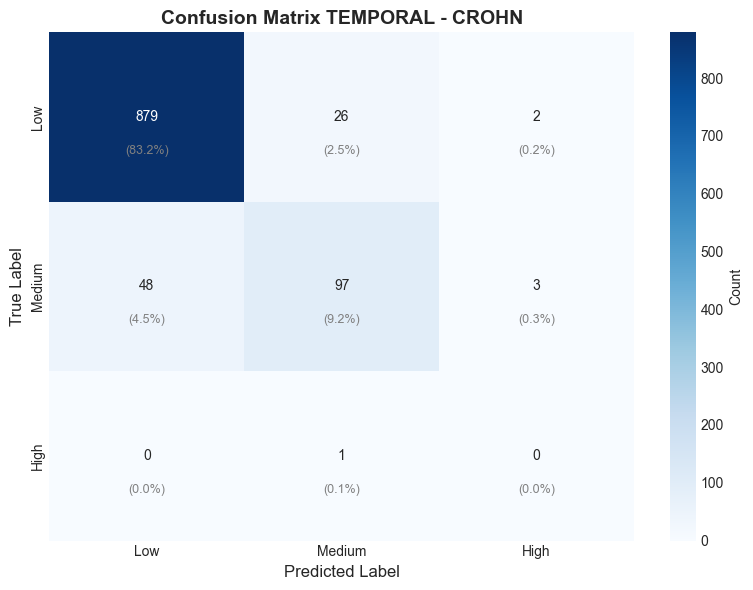

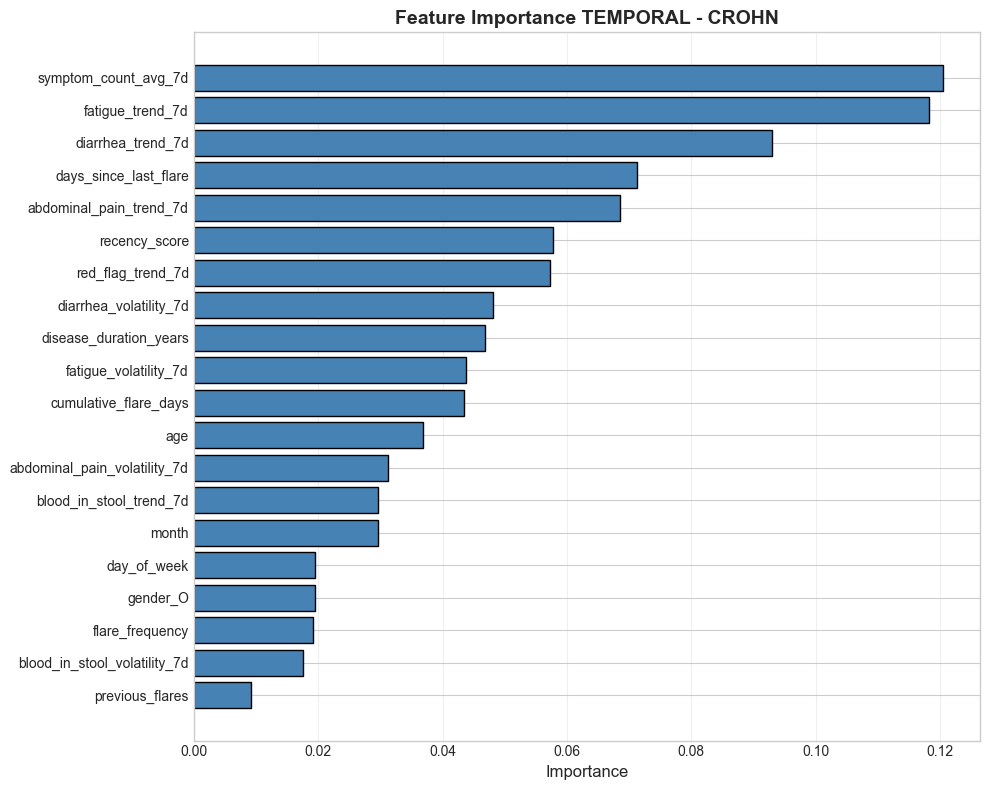

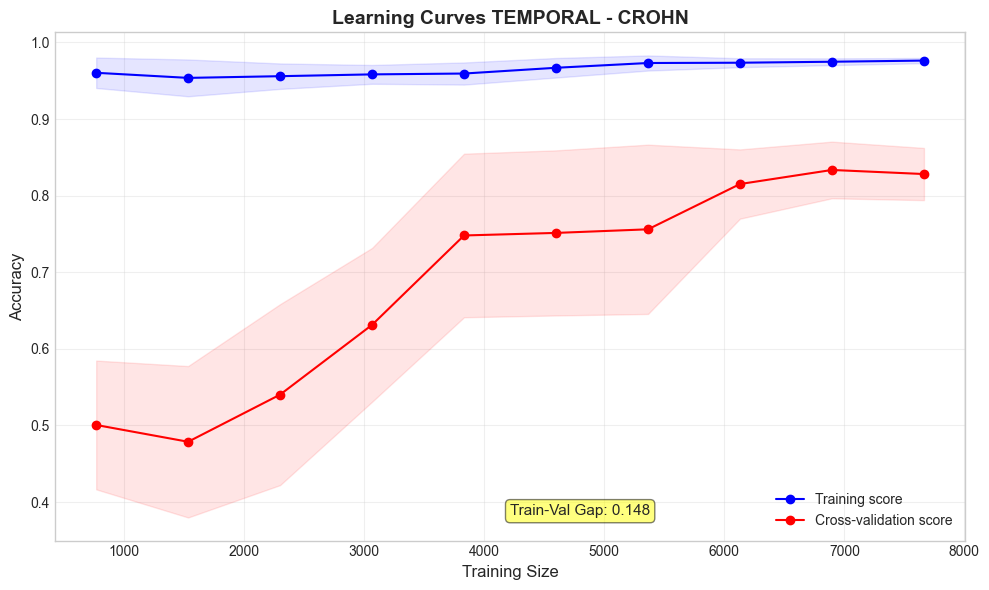

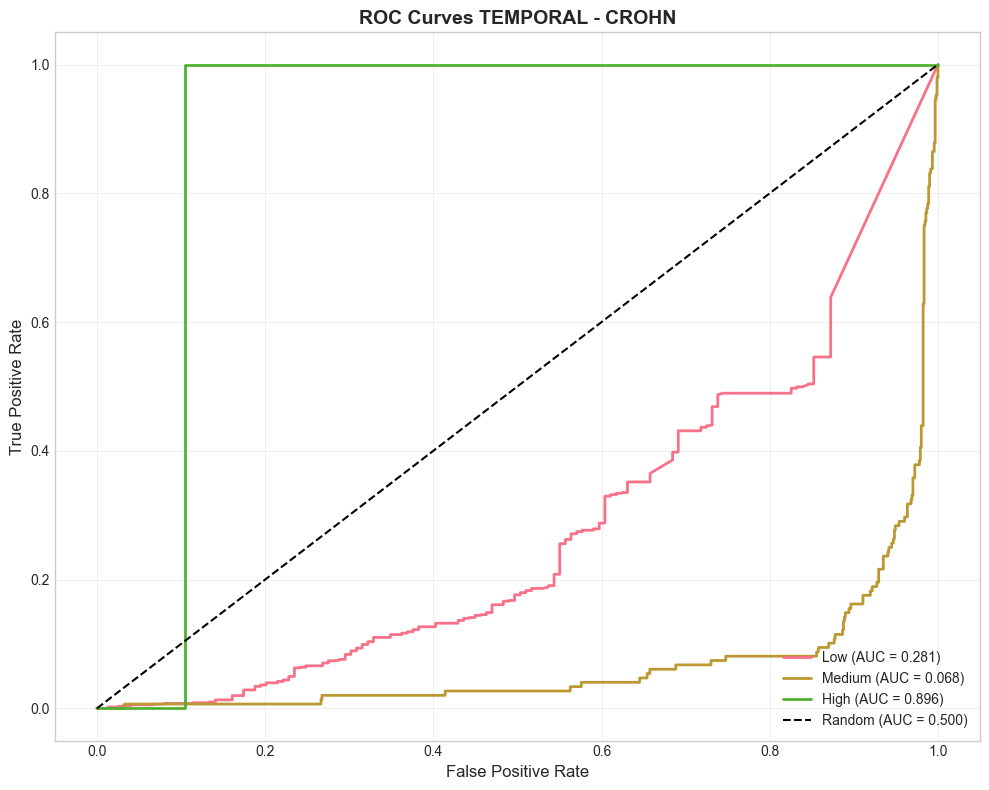


💾 Modelo guardado: ../models/crohn/rf_temporal_classifier.pkl

✅ CROHN completado!

ENTRENANDO: CU - TEMPORAL VALIDATION

✓ Dataset temporal cargado: 5,307 registros
  Distribución target: {'low': 4625, 'medium': 665, 'high': 17}

✅ Features: 27
  ['biologics_active', 'immunosuppressants_active', 'corticosteroids_active', 'aminosalicylates_active', 'total_ibd_meds', 'abdominal_pain_trend_7d', 'abdominal_pain_volatility_7d', 'diarrhea_trend_7d', 'diarrhea_volatility_7d', 'fatigue_trend_7d', 'fatigue_volatility_7d', 'blood_in_stool_trend_7d', 'blood_in_stool_volatility_7d', 'symptom_count_avg_7d', 'red_flag_trend_7d', 'disease_duration_years', 'cumulative_flare_days', 'previous_flares', 'days_since_last_flare', 'flare_frequency', 'recency_score', 'age', 'month', 'day_of_week', 'is_weekend', 'gender_M', 'gender_O']

⏱️ TEMPORAL SPLIT:
  Split date: 2018-11-29
  Train: 4,243 registros (antes de 2018-11-29)
  Test: 1,064 registros (desde 2018-11-29)
  Train distribution: {'low': 3664, 'med

  CV Accuracy: 0.948 (+/- 0.003)

2️⃣ Entrenando modelo final...



✅ RESULTADOS TEMPORALES:
  CV Accuracy: 0.948 ± 0.003
  Test Accuracy: 0.885
  Test F1-score: 0.876
  Gap (CV vs Test): 0.063

📊 Classification Report:
              precision    recall  f1-score   support

        high       0.00      0.00      0.00         4
         low       0.92      0.95      0.94       961
      medium       0.38      0.26      0.31        99

    accuracy                           0.89      1064
   macro avg       0.43      0.41      0.42      1064
weighted avg       0.87      0.89      0.88      1064


3️⃣ Generando gráficos de diagnóstico...


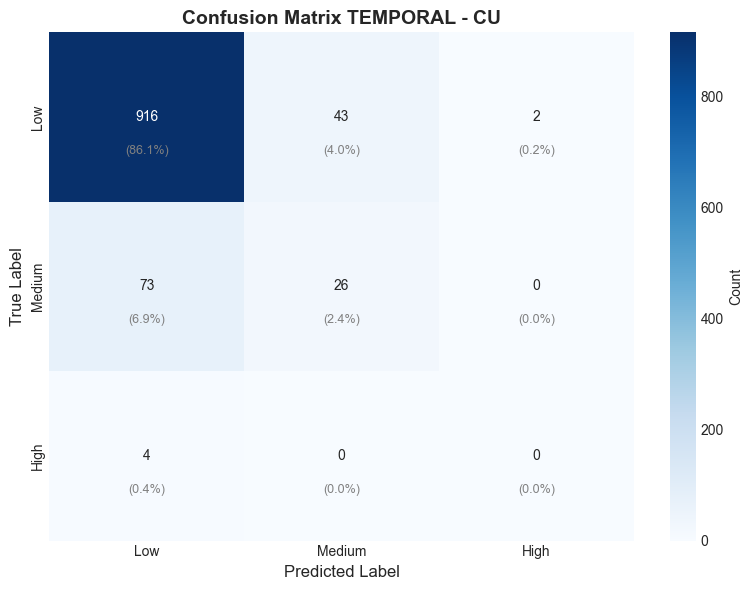

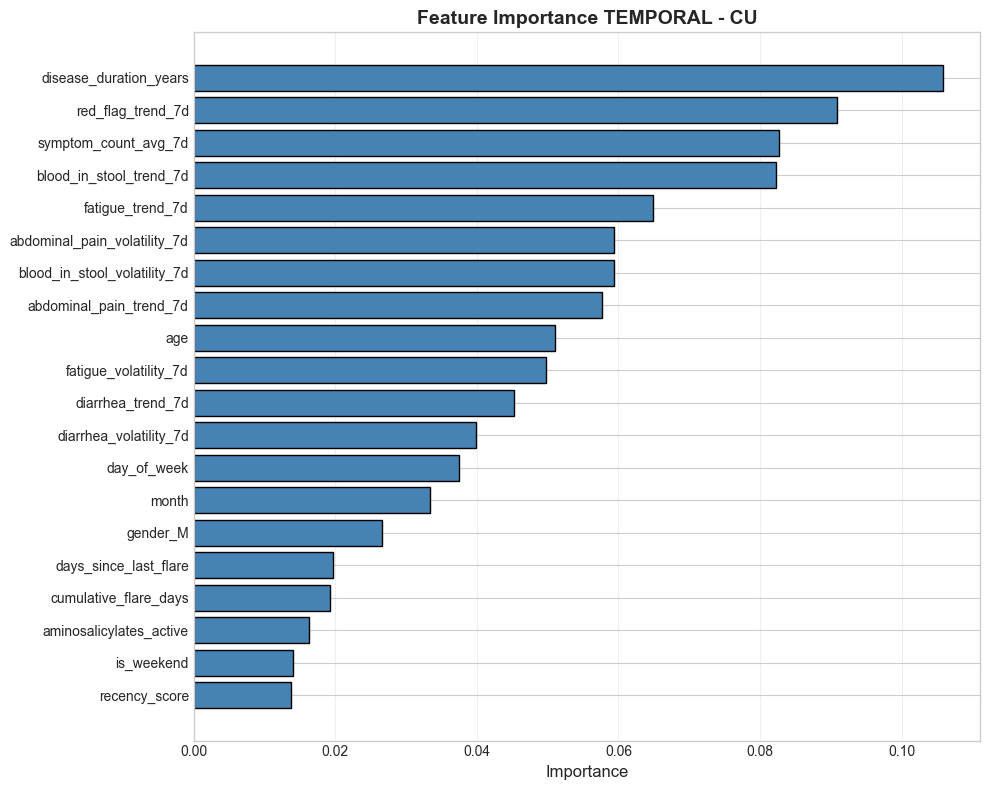

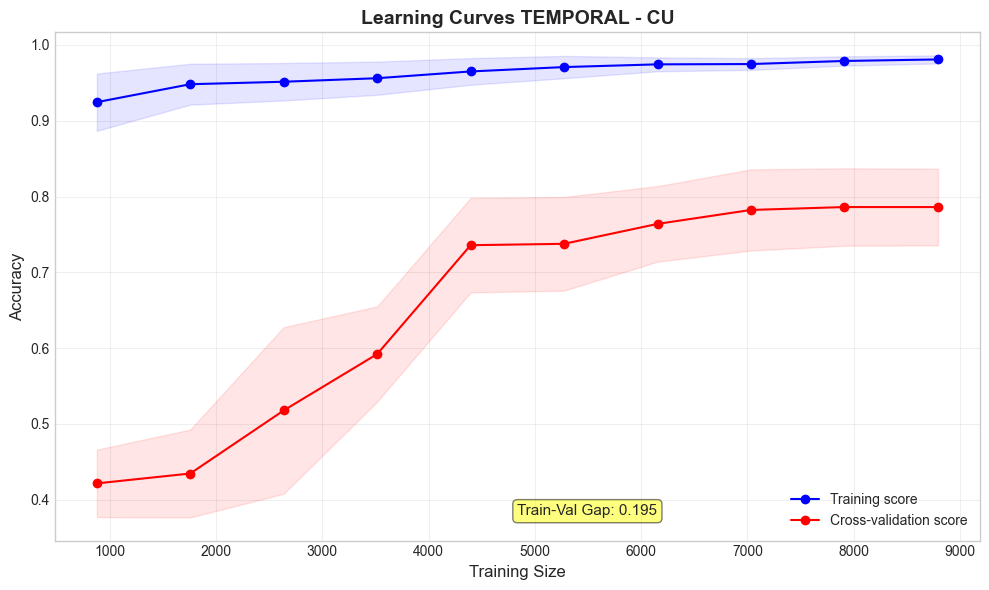

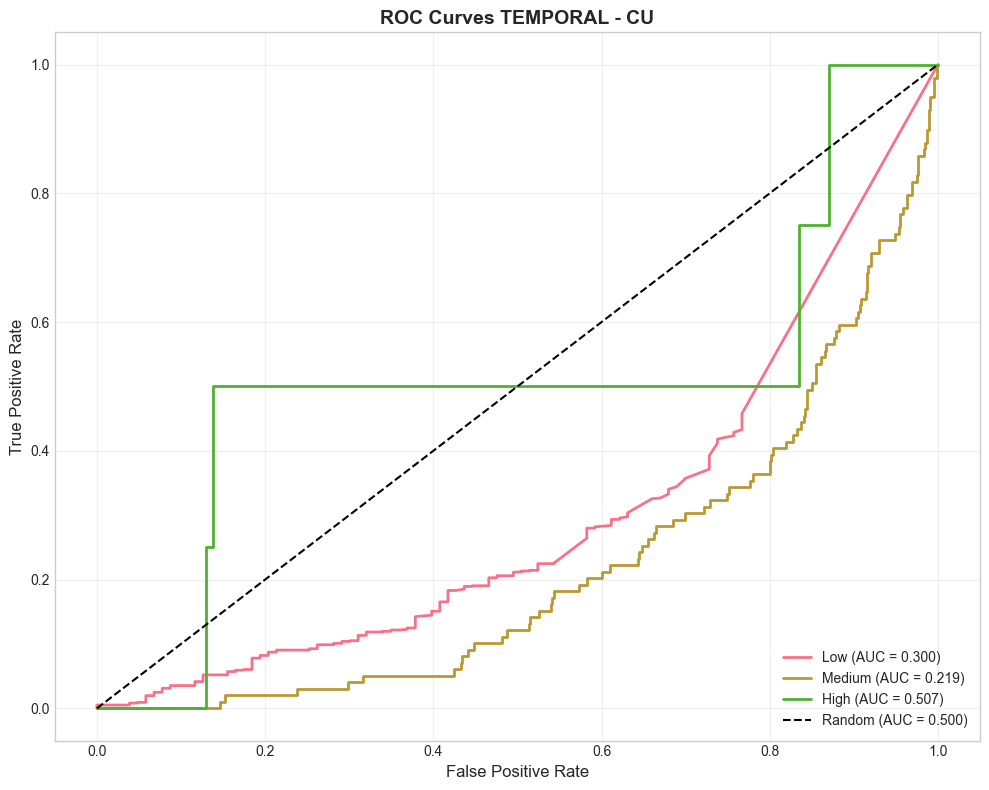


💾 Modelo guardado: ../models/cu/rf_temporal_classifier.pkl

✅ CU completado!

✅ ENTRENAMIENTO TEMPORAL COMPLETADO

Crohn - Test Accuracy: 92.4%
CU - Test Accuracy: 88.5%


In [4]:
# Train Crohn
rf_crohn, crohn_meta = train_temporal('crohn')

# Train CU
rf_cu, cu_meta = train_temporal('cu')

print("\n" + "="*80)
print("✅ ENTRENAMIENTO TEMPORAL COMPLETADO")
print("="*80)
print(f"\nCrohn - Test Accuracy: {crohn_meta['test_accuracy']:.1%}")
print(f"CU - Test Accuracy: {cu_meta['test_accuracy']:.1%}")